# Generation of candidates

## Basic properties of the *covariance*

All MH-algorithms that we consider use a multivariate Gaussian distribution as proposal distribution centered in some state $\mathbf{x} \in \Omega$ where $\Omega$ is the state space.

Often $\mathbf{x}$ is the current state $\mathbf{x}_n$ but this is not necessary. In general, the covariance of the proposal distribution is written as $\sigma^2 \mathbf{C}$ where $\sigma$ is called the *global scale* and $\mathbf{C}$ is a *positive definite matrix*. Adaptive MH algorithms update $\sigma$ and/or $\mathbf{C}$.

Some important properties of a positive definite matrix $\mathbf{C}$ are
    
   * the *eigenvectors* $\mathbf{e}_i$ for $i = 1, 2, \cdots , d$ of $\mathbf{C}$ 
     are pairwise orthogonal, and 
   * its  *eigenvalues* $\lambda_i$ are real and positive: $\lambda_i > 0$ for all $i$ 
   * In the basis consisting of the normalized eigenvectors the matrix $\mathbf{C}$ 
     becomes diagonal. In other words, the matrix $\mathbf{B}$ whose rows are the normalized        eigenvectors of $\mathbf{C}$ represents a *orthogonal transformation*, i.e. 
     
     $$\mathbf{B} \mathbf{B}^\top = \mathbb{1}_d = \mathbf{B}^\top \mathbf{B}$$
     
     and 
     
     $$\mathbf{C} = \mathbf{B} \mathbf{D} \mathbf{B}^\top$$
     
     where $\mathbf{D}$ is the diagonal matrix of the eigenvalues of $\mathbf{C}$
     
     $$\mathbf{D} = \begin{bmatrix}
                        \lambda_{1} & & \\
                        & \ddots & \\
                        & & \lambda_{d}
                    \end{bmatrix}$$
     

Another important property is that a positive definite $\mathbf{C}$ has a *unique Cholesky decomposition*, i.e. $\mathbf{C} = \mathbf{L} \mathbf{L}^\top$ where $\mathbf{L}$ is a lower triangle matrix with positive elements on the diagonal, i.e. all $l_{ii} > 0$.
     $$\mathbf{L} = \begin{bmatrix}
                        l_{11} & & \\
                        l_{12} & l_{22} & \\
                        \cdots \\
                        \cdots \\
                        l_{1d} & l_{2d} & l_{3d} \cdots l_{dd}
                    \end{bmatrix}$$


In case $\mathbf{C}$ is diagonal then $\mathbf{L} = \mathbf{D}^{1/2}$.

## Transformation of sampes from the standard Gaussian distribution

To generate a sample $\mathbf{x}^{*}$ from the multivariate Gaussian distribution with mean $\mathbf{x}$ and covariance $\sigma^2 \mathbf{C}$, i.e. 
    $$\mathbf{x}^{*} \sim N(\mathbf{x}, \sigma^2 \mathbf{C})$$ 
    
is equivalent to generate a sample $\mathbf{z}$ from the *standard Gaussian* distribution $N(\mathbf{0}, \mathbb{1}_d)$ and to transform it as
    $$\mathbf{x}^{*} = \mathbf{x} + \sigma \mathbf{L}\mathbf{z}$$ 
    
Here, $\mathbf{x}$ is the mean of the proposal distribution and $\mathbf{L}$ is the Cholesky factor of $\mathbf{C}$.

If we can express the update of $\mathbf{C}$ in terms of $\mathbf{L}$ then we do not need $\mathbf{C}$ anymore.

This has a number of advantages:

   * **REMARK BM** *Complete the list the advantages*, 
   * E.g. updating $L$ is numerical more stable than updating $\mathbf{C}$, i.e. $\mathbf{C}$ 
     might become **singular**
   * We only need to generate samples from the standard Gaussian distribution $N(\mathbf{0}, \mathbb{1}_d)$.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as ss
import seaborn as sns
import math
import random
import numba
from collections import namedtuple

In [2]:
plt.style.use('classic') #'seaborn-whitegrid'
sns.set()
%precision 4
%matplotlib inline
# To reload modules

In [3]:
import importlib

In [4]:
def generate_sample(center, L, scale, z):
    return center + scale*L@z

# Time to Test

## Test Procedure 

   * First, we generate samples from a multivariate Gaussian distribution with random mean $\mathbf{m}$ and 
   covariance $\mathbf{C}$
   
   * Second, we factorize $\mathbf{C} = \sigma^2 \mathbf{C}_{n}$ where $\det (\mathbf{C}_{n}) = 1$
   
   * Third, we obtain the Cholesky factor $\mathbf{L}$ of $\mathbf{C}_{n}$
   
   * Fourth, we use $\sigma$, $\mathbf{L}$ and $\mathbf{z} \sim N(\mathbf{0}, \mathbb{1}_d)$ to obtain the samples
    $$\mathbf{m} + \sigma \mathbf{L}\mathbf{z}$$
    
   * We scatter the samples obtained in step one and four and the spread should be similar.

In [5]:
def random_Gaussian(d):
    # mean = np.random.random(size=d)
    # X = np.random.random(size=(d, d))
    mean = np.random.uniform(low=-10, high=10, size=d)
    X = np.random.uniform(low=-10, high=10, size=(d, d))
    cov = X.T@X
    return mean, cov

def samples_random_Gaussian(d, N):
    m, C = random_Gaussian(d=d)
    samples = ss.multivariate_normal.rvs(mean=m, cov=C, size=N)
    return samples, m, C

In [6]:
def test_generate_candidate(d, N):
    # Generate samples from a Gaussian with random mean and covariance
    samples, mean, cov = samples_random_Gaussian(d=d, N=N)
    
    # Calculate the normalize Cholesky factor L
    scale = la.det(cov)
    n_cov = cov/scale**2
    n_L = la.cholesky(n_cov)
    
    # Generate samples from the standard normal procedure
    z_samples = ss.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d), size=N)
    
    # Transform the z_samples
    L_generated_samples = np.zeros_like(z_samples)
    for idx, z_sample in enumerate(z_samples):
        L_generated_samples[idx] = generate_sample(center=mean, L=n_L, scale=scale, z=z_sample)
    return samples, L_generated_samples, mean, cov

In [7]:
SAMPLES, L_GENERATED_SAMPLES, MEAN, COV = test_generate_candidate(d=5, N=10000)

In [8]:
from Visualization import compare_sample_spread

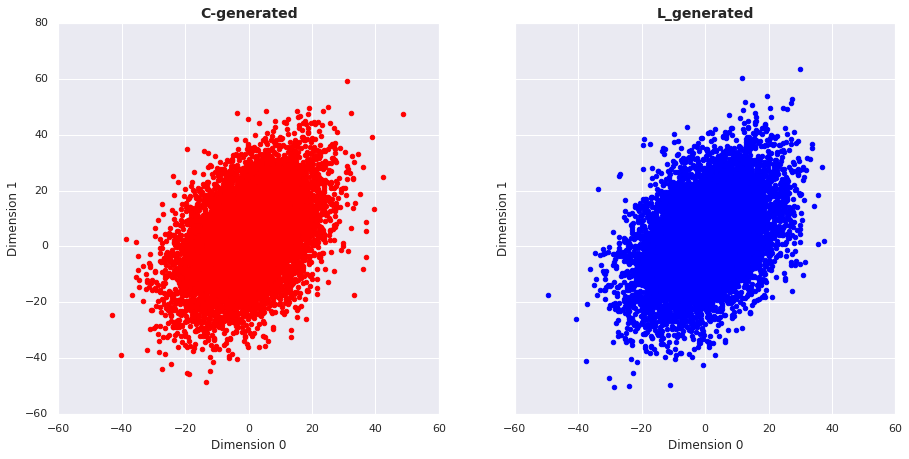

In [9]:
compare_sample_spread(dim1=0, dim2=1, 
                      list_of_samples=[SAMPLES, L_GENERATED_SAMPLES],
                      colors=['red', 'blue'], titles=['C-generated', 'L_generated'])

In [10]:
MEAN, COV

(array([ 0.1687,  3.0654,  9.0309, -9.9151,  0.3118]),
 array([[ 118.869 ,   65.3882,   73.3776,    1.0667,   75.0779],
        [  65.3882,  198.8125,  101.0159, -150.5682,   57.9707],
        [  73.3776,  101.0159,  134.5917,    0.5121,  100.5057],
        [   1.0667, -150.5682,    0.5121,  194.5014,   -9.2478],
        [  75.0779,   57.9707,  100.5057,   -9.2478,  276.8817]]))